# Preprocess precipitation and temperature for fitting

2022.11.08 Kurama Okubo

This notebook conducts preprocessing of precipitation and temperature.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
import time
from datetime import timedelta
import matplotlib.dates as dates
from tqdm import tqdm
import warnings
from scipy.signal import butter, filtfilt, freqz
from scipy import interpolate

import h5py

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
figdir = "../figure/preprocess_precipandtemp"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# read uniform tvec from h5 dataset
root = "../processed_data/"
h5_stats_list = [
                  root+"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                  root+"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

fi = h5py.File(h5_stats_list[0], "r")
uniform_tvec = np.array(fi['uniform_tvec'])

In [4]:
dt = uniform_tvec[1] - uniform_tvec[0]
fs = 1/dt

# 1. Process the tempereature time history

### Data donload
Temperature data is donwloaded from https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USR0000CPAR/detail. 


In [5]:
finame = "../data/parkfield_temperature_noaa_2022.csv"
df_origin = pd.read_csv(finame)
df_origin["datetime"] = pd.to_datetime(df_origin.DATE)
df_origin = df_origin.set_index("datetime")

## Remove error data in measurement
http://berkeleyearth.lbl.gov/stations/172672 reported that data quality is failed on 2003/7.

**However, no spikes are shown in daily data, so it does not affact the model fitting.**

(12053.0, 12387.0)

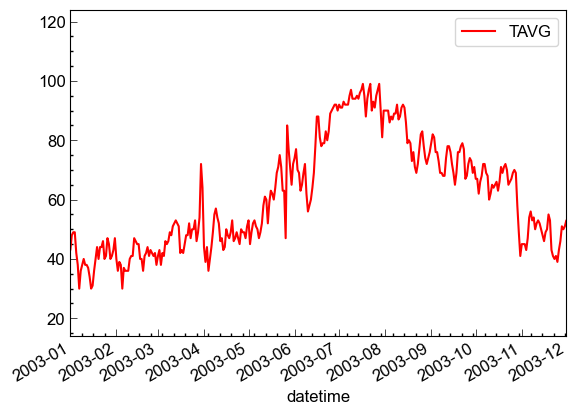

In [6]:
df_origin.plot(kind='line',use_index=True,y='TAVG', color='red')
ax = plt.gca()
xmin = datetime.datetime(2003, 1, 1)
xmax = datetime.datetime(2003, 12, 1)

ax.set_xlim(xmin, xmax)

<AxesSubplot:>

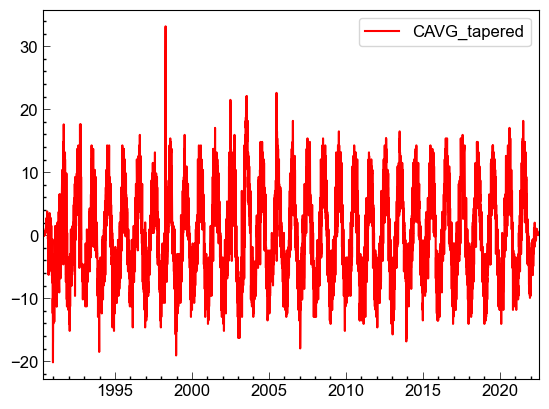

In [7]:
# convert F to C
def fahr_to_celsius(temp_fahr):
    """Convert Fahrenheit to Celsius
    
    Return Celsius conversion of input"""
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius

df_origin["CMAX"] = fahr_to_celsius(df_origin["TMAX"])
df_origin["CMIN"] = fahr_to_celsius(df_origin["TMIN"])
df_origin["CAVG"] = fahr_to_celsius(df_origin["TAVG"])

# linear interpolate datagap with 1days
df_reindexed = df_origin.reindex(pd.date_range(start=df_origin.index.min(),
                                                  end=df_origin.index.max(),
                                                  freq='1D'))

df_interpolated = df_reindexed.interpolate(method='linear')

# demean temperature
df_interpolated["CMAX_demean"] = df_interpolated["CMAX"].copy().sub(np.mean(df_interpolated["CMAX"]))
df_interpolated["CMIN_demean"] = df_interpolated["CMIN"].copy().sub(np.mean(df_interpolated["CMIN"]))
df_interpolated["CAVG_demean"] = df_interpolated["CAVG"].copy().sub(np.mean(df_interpolated["CAVG"]))

# apply cosine taper
from scipy import signal
window = signal.tukey(df_interpolated.index.size, alpha=0.05)
df_interpolated["CMAX_tapered"] = df_interpolated["CMAX_demean"].copy().mul(window)
df_interpolated["CMIN_tapered"] = df_interpolated["CMIN_demean"].copy().mul(window)
df_interpolated["CAVG_tapered"] = df_interpolated["CAVG_demean"].copy().mul(window)
df_interpolated.plot(kind='line',use_index=True,y='CAVG_tapered', color='red')


In [8]:
df_interpolated

,STATION,NAME,DATE,TAVG,TMAX,TMIN,CMAX,CMIN,CAVG,CMAX_demean,CMIN_demean,CAVG_demean,CMAX_tapered,CMIN_tapered,CAVG_tapered
1990-05-02,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-02,65.0,84.0,48.0,28.888889,8.888889,18.333333,3.565019,2.899013,3.143090,0.000000,0.000000,0.000000
1990-05-03,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-03,67.0,92.0,42.0,33.333333,5.555556,19.444444,8.009464,-0.434320,4.254201,0.000228,-0.000012,0.000121
1990-05-04,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-04,73.0,96.0,47.0,35.555556,8.333333,22.777778,10.231686,2.343458,7.587534,0.001166,0.000267,0.000865
1990-05-05,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-05,76.0,101.0,48.0,38.333333,8.888889,24.444444,13.009464,2.899013,9.254201,0.003337,0.000744,0.002374
1990-05-06,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-06,72.0,96.0,47.0,35.555556,8.333333,22.222222,10.231686,2.343458,7.031979,0.004665,0.001069,0.003206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-18,81.0,99.0,65.0,37.222222,18.333333,27.222222,11.898353,12.343458,12.031979,0.005425,0.005628,0.005486
2022-07-19,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-19,83.0,103.0,61.0,39.444444,16.111111,28.333333,14.120575,10.121236,13.143090,0.003622,0.002596,0.003371
2022-07-20,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-20,84.0,104.0,58.0,40.000000,14.444444,28.888889,14.676130,8.454569,13.698645,0.001673,0.000964,0.001562
2022-07-21,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-21,84.0,106.0,59.0,41.111111,15.000000,28.888889,15.787242,9.010125,13.698645,0.000450,0.000257,0.000390


In [9]:
# reference: https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
# apply low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [10]:
dt_temp = df_interpolated["CAVG_tapered"].index.freq.delta.total_seconds()
fs_temp = 1/dt_temp

In [11]:
CAVG_tapered = np.array(df_interpolated["CAVG_tapered"])

In [12]:
1 / fs_temp

86400.0

/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_33524/3141943347.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot((0.5*fs_temp*w/np.pi)**(-1)/86400, np.abs(h), 'b')


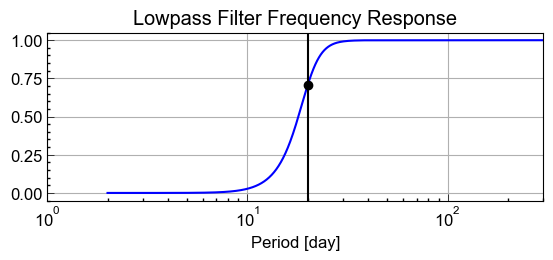

In [13]:
cutoff_period = 20 * 86400 # 20 day in cut-off freq
cutoff_freq = 1/cutoff_period
order = 5

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff_freq, fs_temp, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot((0.5*fs_temp*w/np.pi)**(-1)/86400, np.abs(h), 'b')
ax = plt.gca()
ax.set_xscale('log')
plt.plot(1/cutoff_freq/86400, 0.5*np.sqrt(2), 'ko')
plt.axvline(1/cutoff_freq/86400, color='k')
plt.xlim(1, 300)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Period [day]')
plt.grid()

In [14]:
CAVG_tapered_lowpass = butter_lowpass_filter(CAVG_tapered, cutoff_freq, fs_temp, order)

In [15]:
temp_original_unix_t = df_interpolated.index.view(np.int64) // 10**9

In [16]:
# downsample to synchronize with uniform_tvec
f_temp = interpolate.interp1d(temp_original_unix_t, CAVG_tapered_lowpass, kind="linear")
CAVG_tapered_lowpassed_downsampled = f_temp(uniform_tvec)

In [17]:
uniform_tvec_datetime = [datetime.datetime.fromtimestamp(x) for x in uniform_tvec]

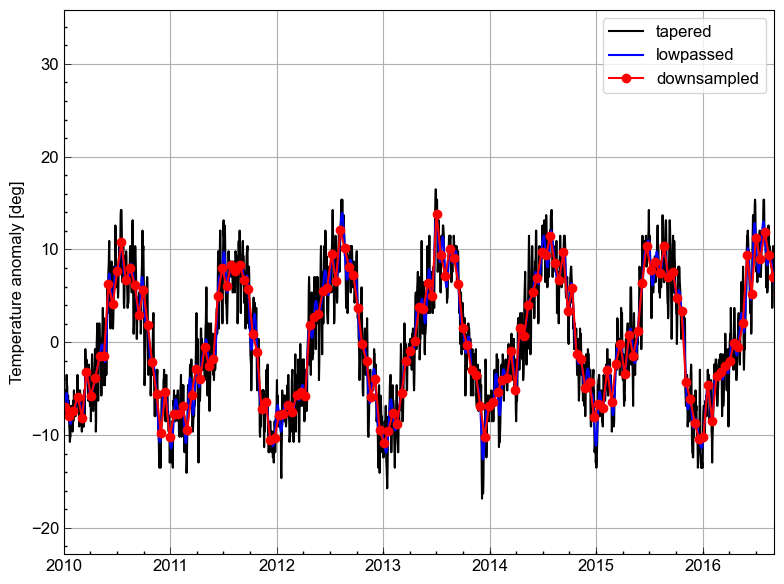

In [18]:
# plot to check result
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(df_interpolated.index, CAVG_tapered, "k-", label="tapered")
ax.plot(df_interpolated.index, CAVG_tapered_lowpass, "b-", label="lowpassed")
ax.plot(uniform_tvec_datetime, CAVG_tapered_lowpassed_downsampled, "r-o", label="downsampled")
xmin = datetime.datetime(2010, 1, 1)
xmax = datetime.datetime(2016, 9, 1)
ax.set_xlim(xmin, xmax)
ax.grid(True)
ax.legend(loc=1)
ax.set_ylabel("Temperature anomaly [deg]")
plt.tight_layout()
plt.savefig(figdir+"/temperature_downsampled.png", dpi=300)

In [19]:
# make new datafame for downsampled temperature and save to csv
df_downsampled = pd.DataFrame(columns= ["t", "CAVG"])
df_downsampled["t"] = uniform_tvec_datetime
df_downsampled["CAVG"] = CAVG_tapered_lowpassed_downsampled
# df_downsampled.to_csv("../data/thermoelasticstrain_temperature_preprocessed.csv")


# 2. Process on precipitation 

We downloaded monthly precipitation data from the Wildland Fire Remote Automated Weather Stations (RAWS) between 2001-2022 at Parkfield.

https://raws.dri.edu/cgi-bin/rawMAIN.pl?caCPAR (monthly summary time series)

2022.11.08 The data is not available in noaa, so we switch the data from the different web archive.




In [20]:
# read precipitation data at Monterey country.
df_precip = pd.read_csv("../data/Parkfield_California_Precipitation_2001-2022_RAWS.csv", header=3)
df_precip["Year"]    = [int(x[3:7]) for x in df_precip.Date.values.astype(str)]
df_precip["Month"] = [int(x[0:2]) for x in df_precip.Date.values.astype(str)]
df_precip["datetime"] = [datetime.datetime(x, y, 15) for x, y in zip(df_precip["Year"], df_precip["Month"])]


In [21]:
df_precip

,Date,mm,Year,Month,datetime
0,01/2001,0.00,2001,1,2001-01-15
1,02/2001,209.00,2001,2,2001-02-15
2,03/2001,91.44,2001,3,2001-03-15
3,04/2001,10.16,2001,4,2001-04-15
4,05/2001,0.00,2001,5,2001-05-15
...,...,...,...,...,...
257,06/2022,0.00,2022,6,2022-06-15
258,07/2022,0.00,2022,7,2022-07-15
259,08/2022,0.00,2022,8,2022-08-15
260,09/2022,19.30,2022,9,2022-09-15


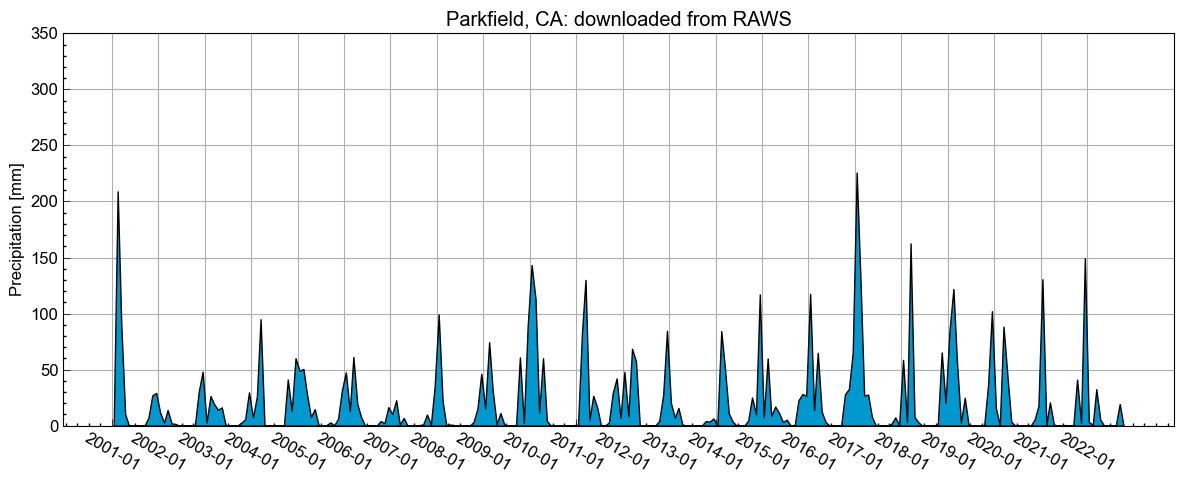

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

fc = (0, 0.6, 0.81)
ax.fill_between(df_precip.datetime, df_precip.mm, lw=1, edgecolor="k", facecolor=fc, alpha=1, zorder=2)

ax.set_ylabel("Precipitation [mm]")
ax.set_ylim(0, 350)
ax.set_title("Parkfield, CA: downloaded from RAWS")
ax.grid(True, zorder=1)
# axs[0].legend(loc=4)

ax.set_xticks([datetime.datetime(x, 1, 1) for x in range(2001, 2023)])
xfmt = dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-30)
plt.tight_layout()

plt.savefig(figdir+"/precipitation_Monterey_country_2001-2021.png", format="png", dpi=150)


In [23]:
# linear interpolation on the uniform_tvec (upsampling)
precip_t = df_precip["datetime"].view(np.int64) // 10**9
precip_t
f_precip = interpolate.interp1d(precip_t, df_precip["mm"], kind="linear")
precip_resampled = f_precip(uniform_tvec)

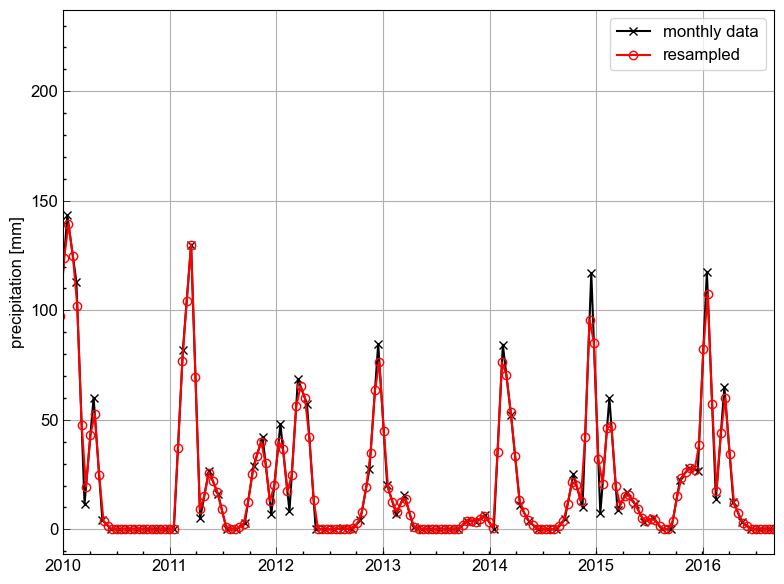

In [24]:
# plot to check result
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(df_precip["datetime"], df_precip["mm"], "kx-", label="monthly data")
ax.plot(uniform_tvec_datetime, precip_resampled, "ro-", label="resampled", markerfacecolor="None")
xmin = datetime.datetime(2010, 1, 1)
xmax = datetime.datetime(2016, 9, 1)
ax.set_xlim(xmin, xmax)
ax.set_ylabel("precipitation [mm]")
ax.grid(True)
ax.legend(loc=1)
plt.tight_layout()
plt.savefig(figdir+"/precip_resampled.png", dpi=300)

**NOTE:** The total precipitation should be scaled after resampling. However, as we focus only on the trend of the precipitation, not the amplitude of precipitation, to fit the model of the change in ground water level to the dv/v time history, we didn't apply the scaling in the result here for the sake of simplicity.
This assumes that the precipitation is uniformly distributed over the month, and we resample the precipitation with different time bins. This can be linearly done as shown in the schematic below.

(0.0, 2.5)

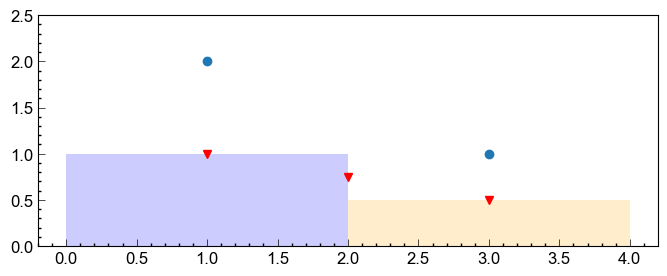

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.fill_between([0, 2], [1, 1], fc = "b", alpha=0.2)
ax.fill_between([2, 4], [0.5, 0.5], fc = "orange", alpha=0.2)
ax.plot([1, 3], [2, 1], "o")
ax.plot([1, 2, 3], [1, 3/4, 0.5], "rv")
ax.set_ylim([0, 2.5])

In [26]:
#join the dataframe and save to csv for next step with Julia

df_tempandprecip = pd.DataFrame(columns= ["t", "CAVG", "precip"])
df_tempandprecip["t"] = uniform_tvec_datetime
df_tempandprecip["CAVG"] = CAVG_tapered_lowpassed_downsampled
df_tempandprecip["precip"] = precip_resampled

df_tempandprecip.to_csv("../data/interped_tempandprecip.csv")


<AxesSubplot:xlabel='t'>

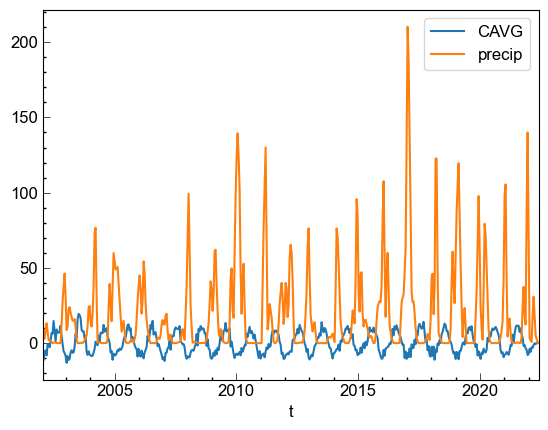

In [27]:
df_tempandprecip.set_index("t").plot()

# Save for longterm data to reconstruct the models

In [28]:
starttime = datetime.datetime(2001, 1, 6) # choose start time to synchronize with uniform_tvec from 2002-01-01
endtime = datetime.datetime(2022, 6, 1)
cc_time_unit=86400 # short-stacking time unit
averagestack_factor=30 # length of time bin to compute mean and std
datefreq = '15D'

st_center = (averagestack_factor*cc_time_unit/86400)/2
date_range_st = starttime + datetime.timedelta(days=st_center) # day

longtermdates = pd.date_range(start=date_range_st, end=endtime, freq=datefreq)

date_range_st = starttime + datetime.timedelta(days=st_center) # day

longterm_tvec = longtermdates.date

In [29]:
longterm_tvec_unix = [int(time.mktime(x.timetuple())) for x in longterm_tvec]

In [30]:
CAVG_tapered_longterm = f_temp(longterm_tvec_unix)
precip_resampled_longterm = f_precip(longterm_tvec_unix)

In [31]:
#join the dataframe and save to csv for next step with Julia
df_tempandprecip_long = pd.DataFrame(columns= ["t", "CAVG", "precip"])
df_tempandprecip_long["t"] = longterm_tvec
df_tempandprecip_long["CAVG"] = CAVG_tapered_longterm
df_tempandprecip_long["precip"] = precip_resampled_longterm
df_tempandprecip_long.to_csv("../data/interped_tempandprecip_longterm.csv")


<AxesSubplot:xlabel='t'>

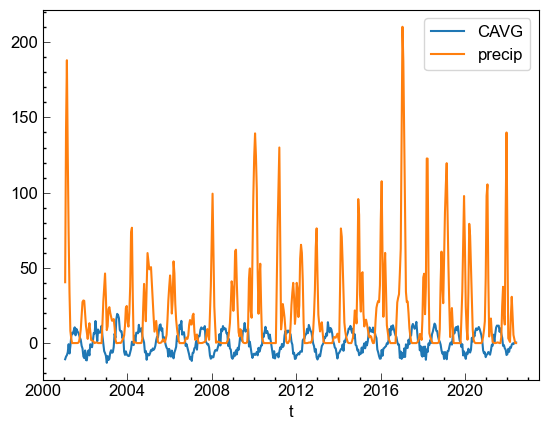

In [32]:
df_tempandprecip_long.set_index("t").plot()

# Plot master figures

In [33]:
#. Temperature and precipitation

In [34]:
df_interpolated

,STATION,NAME,DATE,TAVG,TMAX,TMIN,CMAX,CMIN,CAVG,CMAX_demean,CMIN_demean,CAVG_demean,CMAX_tapered,CMIN_tapered,CAVG_tapered
1990-05-02,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-02,65.0,84.0,48.0,28.888889,8.888889,18.333333,3.565019,2.899013,3.143090,0.000000,0.000000,0.000000
1990-05-03,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-03,67.0,92.0,42.0,33.333333,5.555556,19.444444,8.009464,-0.434320,4.254201,0.000228,-0.000012,0.000121
1990-05-04,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-04,73.0,96.0,47.0,35.555556,8.333333,22.777778,10.231686,2.343458,7.587534,0.001166,0.000267,0.000865
1990-05-05,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-05,76.0,101.0,48.0,38.333333,8.888889,24.444444,13.009464,2.899013,9.254201,0.003337,0.000744,0.002374
1990-05-06,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",1990-05-06,72.0,96.0,47.0,35.555556,8.333333,22.222222,10.231686,2.343458,7.031979,0.004665,0.001069,0.003206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-18,81.0,99.0,65.0,37.222222,18.333333,27.222222,11.898353,12.343458,12.031979,0.005425,0.005628,0.005486
2022-07-19,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-19,83.0,103.0,61.0,39.444444,16.111111,28.333333,14.120575,10.121236,13.143090,0.003622,0.002596,0.003371
2022-07-20,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-20,84.0,104.0,58.0,40.000000,14.444444,28.888889,14.676130,8.454569,13.698645,0.001673,0.000964,0.001562
2022-07-21,USR0000CPAR,"PARKFIELD CALIFORNIA, CA US",2022-07-21,84.0,106.0,59.0,41.111111,15.000000,28.888889,15.787242,9.010125,13.698645,0.000450,0.000257,0.000390


In [35]:
df_downsampled

,t,CAVG
0,2002-01-16,-11.288114
1,2002-01-31,-11.496464
2,2002-02-15,-5.984877
3,2002-03-02,-4.825483
4,2002-03-17,-8.167028
...,...,...
492,2022-04-01,-0.224827
493,2022-04-16,-0.717417
494,2022-05-01,0.138853
495,2022-05-16,0.424987


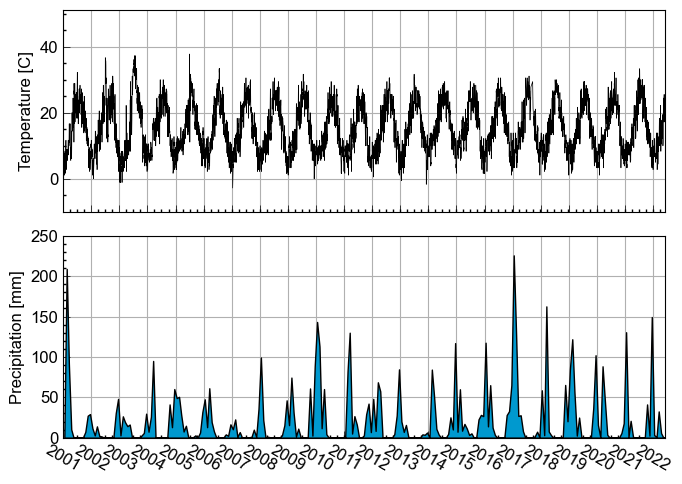

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

axs[0].grid(True)
axs[0].plot(df_interpolated.CAVG, "k-", lw=0.5)
mean_temp = np.mean(df_interpolated.CAVG.values)
# axs[0].plot(df_downsampled.t, df_downsampled.CAVG+mean_temp, "b-", lw=0.5)
axs[0].set_ylabel("Temperature [C]")

fc = (0, 0.6, 0.81)
axs[1].fill_between(df_precip.datetime, df_precip.mm, lw=1, edgecolor="k", facecolor=fc, alpha=1, zorder=2)

axs[1].set_ylabel("Precipitation [mm]")
axs[1].set_ylim(0, 250)
# axs[1].set_title("Parkfield, CA: downloaded from RAWS")
axs[1].grid(True, zorder=1)
axs[1].set_xlim([datetime.datetime(2002, 1,1), datetime.datetime(2022, 6,1)])
axs[1].set_xticks([datetime.datetime(x, 1, 1) for x in range(2001, 2023,1)])

xfmt = dates.DateFormatter('%Y')
axs[1].xaxis.set_major_formatter(xfmt)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=-30)
plt.tight_layout()

plt.savefig(figdir+"/temperature_and_precipitation_Parkfield.png", format="png", dpi=150)


In [37]:
fc = (0, 0.6, 0.81)
ax.fill_between(df_precip.datetime, df_precip.mm, lw=1, edgecolor="k", facecolor=fc, alpha=1, zorder=2)

ax.set_ylabel("Precipitation [mm]")
ax.set_ylim(0, 350)
ax.set_title("Parkfield, CA: downloaded from RAWS")
ax.grid(True, zorder=1)
# axs[0].legend(loc=4)

ax.set_xticks([datetime.datetime(x, 1, 1) for x in range(2001, 2023)])
xfmt = dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-30)
plt.tight_layout()

plt.savefig(figdir+"/precipitation_Monterey_country_2001-2021.png", format="png", dpi=150)

<Figure size 640x480 with 0 Axes>

In [38]:
df_downsampled

,t,CAVG
0,2002-01-16,-11.288114
1,2002-01-31,-11.496464
2,2002-02-15,-5.984877
3,2002-03-02,-4.825483
4,2002-03-17,-8.167028
...,...,...
492,2022-04-01,-0.224827
493,2022-04-16,-0.717417
494,2022-05-01,0.138853
495,2022-05-16,0.424987


# Evaluate the trend in the temperature

In [39]:
longterm_tvec_epochday = (np.array(longterm_tvec_unix) - longterm_tvec_unix[0])/86400
# longterm_tvec_epochday

Text(0.5, 1.0, 'slope 2.482e-02 [deg/year]')

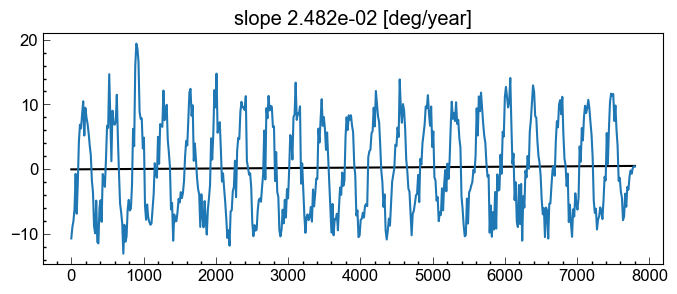

In [40]:
z = np.polyfit(longterm_tvec_epochday, CAVG_tapered_longterm, 1)
p = np.poly1d(z)
temperature_slope = z[0]*365 #[deg/day] -> [deg/year]

fig, ax = plt.subplots(1,1, figsize=(8, 3))
ax.plot(longterm_tvec_epochday, p(longterm_tvec_epochday), "k-")
ax.plot(longterm_tvec_epochday, CAVG_tapered_longterm)
ax.set_title(f"slope {temperature_slope:.3e} [deg/year]")

In [41]:
# compute the total increase over 20 years
stind = np.where(longterm_tvec > datetime.date(2002, 6, 1))[0][0]
temperature_diff = p(longterm_tvec_epochday[-1]) - p(longterm_tvec_epochday[stind])
print(f"increase in temperature over 20 years is {temperature_diff}[degree]." )

increase in temperature over 20 years is 0.49565079751891933[degree].
